In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('D:/Major Project/Dataset/Dynamics/A1237_30deg.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23790 entries, 0 to 23789
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Current(A)      23790 non-null  float64
 1   Voltage(V)      23790 non-null  float64
 2   Temperature(C)  23790 non-null  float64
 3   OCV             23790 non-null  float64
 4   SOC             23790 non-null  float64
dtypes: float64(5)
memory usage: 929.4 KB


In [5]:
data.head()

,Current(A),Voltage(V),Temperature(C),OCV,SOC
0,0.000000,3.075400,31.391201,3.075400,56.0
1,-1.099373,2.888580,31.242373,2.877586,40.0
2,-1.099373,2.876269,31.391201,2.865275,39.0
3,-1.099373,2.864882,31.421654,2.853888,38.0
4,-1.099373,2.853494,31.496058,2.842500,37.0


In [6]:
data.describe()

,Current(A),Voltage(V),Temperature(C),OCV,SOC
count,23790.000000,23790.000000,23790.000000,23790.000000,23790.000000
mean,-0.388217,3.196085,31.992234,3.192203,66.013955
std,0.936439,0.190333,0.224793,0.198055,16.506460
min,-3.849407,2.409066,31.174595,2.400807,0.000000
25%,-0.910321,3.111717,31.840794,3.104365,59.000000
50%,-0.369837,3.213591,31.945593,3.210182,68.000000
75%,0.000378,3.300692,32.107838,3.301309,75.000000
max,2.061073,3.592155,33.004131,3.599857,100.000000


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [8]:
x = data.iloc[:,:-2]
y = data.iloc[:,-1]

In [9]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [10]:
x = x.reshape(23790,3,1)

In [11]:
x

array([[[0.65128501],
        [0.56321543],
        [0.118394  ]],

       [[0.46528109],
        [0.40530684],
        [0.03704634]],

       [[0.46528109],
        [0.39490105],
        [0.118394  ]],

       ...,

       [[0.5985318 ],
        [0.07336105],
        [0.42141713]],

       [[0.56389233],
        [0.03589993],
        [0.51933687]],

       [[0.65128501],
        [0.18886579],
        [0.47130746]]])

In [12]:
y = np.array(y).reshape(23790,1)

In [13]:
y

array([[56.],
       [40.],
       [39.],
       ...,
       [ 8.],
       [ 4.],
       [19.]])

In [14]:
train_input, test_input, train_soc, test_soc = train_test_split(x,y,test_size=0.2, random_state=42)

In [15]:
for i in range(len(train_soc)):
    if train_soc[i] == 0:
        train_soc[i] = 1

In [16]:
for i in range(len(test_soc)):
    if test_soc[i] == 0:
        test_soc[i] = 1

In [17]:
train_input.shape

(19032, 3, 1)

In [18]:
test_input.shape

(4758, 3, 1)

In [19]:
train_soc.shape

(19032, 1)

In [20]:
test_soc.shape

(4758, 1)

In [21]:
from keras.models import Sequential
from keras.layers import  Dense, RepeatVector, TimeDistributed, GRU,Flatten
from keras.optimizers import Adam

In [22]:
# Define the model
model = Sequential()

# Encoder
model.add(Dense(16, input_shape=(3,1),activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Flatten())

# Repeat the context vector to be the input for the decoder
model.add(RepeatVector(1))

# Decoder
model.add(GRU(64, return_sequences=True,activation='sigmoid'))
model.add(GRU(32, return_sequences=True,activation='sigmoid'))
model.add(GRU(16, return_sequences=True,activation='sigmoid'))
model.add(TimeDistributed(Dense(1, activation='linear')))  # Output sequence for regression

In [23]:
# Compile the model with optimizer and loss function
model.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [24]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3, 16)             32        
                                                                 
 dense_1 (Dense)             (None, 3, 32)             544       
                                                                 
 dense_2 (Dense)             (None, 3, 64)             2112      
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 192)            0         
 r)                                                              
                                                                 
 gru (GRU)                   (None, 1, 64)             49536     
                                                        

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,mean_absolute_percentage_error
import time

In [26]:
# Train the model
a1 = time.time()
history = model.fit(train_input, train_soc, epochs=500, batch_size=256,validation_split=0.05)
a2 = time.time()
a = a2-a1

Epoch 1/500
71/71 [==============================] - 4s 11ms/step - loss: 4625.5273 - mae: 65.9908 - val_loss: 4560.2529 - val_mae: 65.5829
Epoch 2/500
71/71 [==============================] - 0s 6ms/step - loss: 4456.6494 - mae: 64.6975 - val_loss: 4419.4253 - val_mae: 64.5002
Epoch 3/500
71/71 [==============================] - 0s 6ms/step - loss: 4347.3701 - mae: 63.8490 - val_loss: 4330.5229 - val_mae: 63.8074
Epoch 4/500
71/71 [==============================] - 0s 6ms/step - loss: 4265.4619 - mae: 63.2048 - val_loss: 4246.7573 - val_mae: 63.1475
Epoch 5/500
71/71 [==============================] - 0s 6ms/step - loss: 4171.4268 - mae: 62.4574 - val_loss: 4149.8154 - val_mae: 62.3752
Epoch 6/500
71/71 [==============================] - 0s 7ms/step - loss: 4083.2300 - mae: 61.7487 - val_loss: 4066.9553 - val_mae: 61.7075
Epoch 7/500
71/71 [==============================] - 0s 6ms/step - loss: 4003.6270 - mae: 61.1024 - val_loss: 3989.4019 - val_mae: 61.0758
Epoch 8/500
71/71 [=======

71/71 [==============================] - 0s 5ms/step - loss: 1433.4882 - mae: 35.0159 - val_loss: 1425.7222 - val_mae: 35.0682
Epoch 60/500
71/71 [==============================] - 0s 5ms/step - loss: 1401.4312 - mae: 34.5839 - val_loss: 1393.6331 - val_mae: 34.6409
Epoch 61/500
71/71 [==============================] - 0s 6ms/step - loss: 1369.9078 - mae: 34.1533 - val_loss: 1362.1400 - val_mae: 34.2161
Epoch 62/500
71/71 [==============================] - 0s 5ms/step - loss: 1338.9301 - mae: 33.7264 - val_loss: 1331.1171 - val_mae: 33.7941
Epoch 63/500
71/71 [==============================] - 0s 5ms/step - loss: 1308.4777 - mae: 33.3004 - val_loss: 1300.6620 - val_mae: 33.3740
Epoch 64/500
71/71 [==============================] - 0s 5ms/step - loss: 1278.5587 - mae: 32.8785 - val_loss: 1270.7382 - val_mae: 32.9571
Epoch 65/500
71/71 [==============================] - 0s 5ms/step - loss: 1249.1609 - mae: 32.4591 - val_loss: 1241.3385 - val_mae: 32.5414
Epoch 66/500
71/71 [=============

71/71 [==============================] - 1s 8ms/step - loss: 358.2672 - mae: 15.5376 - val_loss: 348.9842 - val_mae: 15.3620
Epoch 119/500
71/71 [==============================] - 0s 6ms/step - loss: 352.1172 - mae: 15.3459 - val_loss: 342.7738 - val_mae: 15.1668
Epoch 120/500
71/71 [==============================] - 1s 8ms/step - loss: 346.2731 - mae: 15.1648 - val_loss: 336.9016 - val_mae: 14.9807
Epoch 121/500
71/71 [==============================] - 0s 7ms/step - loss: 340.7259 - mae: 14.9880 - val_loss: 331.3186 - val_mae: 14.7971
Epoch 122/500
71/71 [==============================] - 0s 7ms/step - loss: 335.4719 - mae: 14.8144 - val_loss: 326.0214 - val_mae: 14.6208
Epoch 123/500
71/71 [==============================] - 0s 6ms/step - loss: 330.4922 - mae: 14.6525 - val_loss: 320.9723 - val_mae: 14.4535
Epoch 124/500
71/71 [==============================] - 0s 7ms/step - loss: 325.7851 - mae: 14.4953 - val_loss: 316.2127 - val_mae: 14.2894
Epoch 125/500
71/71 [====================

71/71 [==============================] - 1s 8ms/step - loss: 270.8198 - mae: 12.1263 - val_loss: 259.2511 - val_mae: 11.8213
Epoch 178/500
71/71 [==============================] - 1s 10ms/step - loss: 270.8209 - mae: 12.1243 - val_loss: 259.2467 - val_mae: 11.8202
Epoch 179/500
71/71 [==============================] - 1s 8ms/step - loss: 270.8250 - mae: 12.1283 - val_loss: 259.2513 - val_mae: 11.8214
Epoch 180/500
71/71 [==============================] - 0s 6ms/step - loss: 270.8197 - mae: 12.1251 - val_loss: 259.2452 - val_mae: 11.8198
Epoch 181/500
71/71 [==============================] - 0s 7ms/step - loss: 270.8217 - mae: 12.1248 - val_loss: 259.2467 - val_mae: 11.8202
Epoch 182/500
71/71 [==============================] - 1s 8ms/step - loss: 270.8214 - mae: 12.1223 - val_loss: 259.2368 - val_mae: 11.8176
Epoch 183/500
71/71 [==============================] - 0s 7ms/step - loss: 270.8264 - mae: 12.1271 - val_loss: 259.2458 - val_mae: 11.8200
Epoch 184/500
71/71 [===================

71/71 [==============================] - 1s 7ms/step - loss: 270.8240 - mae: 12.1217 - val_loss: 259.2336 - val_mae: 11.8170
Epoch 237/500
71/71 [==============================] - 1s 7ms/step - loss: 270.8249 - mae: 12.1255 - val_loss: 259.2299 - val_mae: 11.8163
Epoch 238/500
71/71 [==============================] - 1s 8ms/step - loss: 185.6378 - mae: 9.6627 - val_loss: 100.6854 - val_mae: 6.5612
Epoch 239/500
71/71 [==============================] - 1s 7ms/step - loss: 90.8395 - mae: 5.7177 - val_loss: 79.1181 - val_mae: 5.0613
Epoch 240/500
71/71 [==============================] - 1s 7ms/step - loss: 75.5618 - mae: 4.7955 - val_loss: 68.2092 - val_mae: 4.4120
Epoch 241/500
71/71 [==============================] - 1s 7ms/step - loss: 66.1329 - mae: 4.2525 - val_loss: 60.4558 - val_mae: 4.0044
Epoch 242/500
71/71 [==============================] - 1s 7ms/step - loss: 59.1373 - mae: 3.8541 - val_loss: 54.3664 - val_mae: 3.6151
Epoch 243/500
71/71 [==============================] - 1s 7

71/71 [==============================] - 1s 8ms/step - loss: 1.7142 - mae: 0.5685 - val_loss: 1.7930 - val_mae: 0.5402
Epoch 298/500
71/71 [==============================] - 1s 7ms/step - loss: 1.5770 - mae: 0.5381 - val_loss: 1.6772 - val_mae: 0.5290
Epoch 299/500
71/71 [==============================] - 0s 7ms/step - loss: 1.4878 - mae: 0.5480 - val_loss: 1.5854 - val_mae: 0.5349
Epoch 300/500
71/71 [==============================] - 1s 8ms/step - loss: 1.3662 - mae: 0.5187 - val_loss: 1.4714 - val_mae: 0.5166
Epoch 301/500
71/71 [==============================] - 1s 8ms/step - loss: 1.2658 - mae: 0.5028 - val_loss: 1.3642 - val_mae: 0.4932
Epoch 302/500
71/71 [==============================] - 0s 7ms/step - loss: 1.1706 - mae: 0.4868 - val_loss: 1.2909 - val_mae: 0.5003
Epoch 303/500
71/71 [==============================] - 1s 8ms/step - loss: 1.0964 - mae: 0.4842 - val_loss: 1.2013 - val_mae: 0.4813
Epoch 304/500
71/71 [==============================] - 1s 7ms/step - loss: 1.0124 -

Epoch 359/500
71/71 [==============================] - 1s 9ms/step - loss: 0.1177 - mae: 0.2752 - val_loss: 0.1244 - val_mae: 0.2769
Epoch 360/500
71/71 [==============================] - 1s 10ms/step - loss: 0.1148 - mae: 0.2731 - val_loss: 0.1244 - val_mae: 0.2754
Epoch 361/500
71/71 [==============================] - 0s 7ms/step - loss: 0.1113 - mae: 0.2704 - val_loss: 0.1257 - val_mae: 0.2773
Epoch 362/500
71/71 [==============================] - 0s 7ms/step - loss: 0.1164 - mae: 0.2760 - val_loss: 0.1534 - val_mae: 0.3036
Epoch 363/500
71/71 [==============================] - 1s 8ms/step - loss: 0.1230 - mae: 0.2838 - val_loss: 0.1289 - val_mae: 0.2835
Epoch 364/500
71/71 [==============================] - 1s 7ms/step - loss: 0.1149 - mae: 0.2750 - val_loss: 0.1292 - val_mae: 0.2852
Epoch 365/500
71/71 [==============================] - 1s 7ms/step - loss: 0.1186 - mae: 0.2786 - val_loss: 0.1149 - val_mae: 0.2725
Epoch 366/500
71/71 [==============================] - 1s 7ms/step -

71/71 [==============================] - 1s 7ms/step - loss: 0.1034 - mae: 0.2702 - val_loss: 0.1118 - val_mae: 0.2781
Epoch 421/500
71/71 [==============================] - 1s 8ms/step - loss: 0.1191 - mae: 0.2848 - val_loss: 0.0922 - val_mae: 0.2615
Epoch 422/500
71/71 [==============================] - 1s 7ms/step - loss: 0.1004 - mae: 0.2675 - val_loss: 0.1073 - val_mae: 0.2789
Epoch 423/500
71/71 [==============================] - 0s 7ms/step - loss: 0.0968 - mae: 0.2636 - val_loss: 0.0963 - val_mae: 0.2626
Epoch 424/500
71/71 [==============================] - 1s 7ms/step - loss: 0.1208 - mae: 0.2883 - val_loss: 0.1100 - val_mae: 0.2773
Epoch 425/500
71/71 [==============================] - 0s 7ms/step - loss: 0.1206 - mae: 0.2870 - val_loss: 0.0957 - val_mae: 0.2655
Epoch 426/500
71/71 [==============================] - 0s 6ms/step - loss: 0.1124 - mae: 0.2797 - val_loss: 0.1167 - val_mae: 0.2876
Epoch 427/500
71/71 [==============================] - 0s 7ms/step - loss: 0.1023 -

Epoch 482/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0952 - mae: 0.2624 - val_loss: 0.0972 - val_mae: 0.2651
Epoch 483/500
71/71 [==============================] - 1s 7ms/step - loss: 0.0949 - mae: 0.2620 - val_loss: 0.0887 - val_mae: 0.2585
Epoch 484/500
71/71 [==============================] - 1s 7ms/step - loss: 0.1053 - mae: 0.2724 - val_loss: 0.0959 - val_mae: 0.2674
Epoch 485/500
71/71 [==============================] - 1s 7ms/step - loss: 0.0965 - mae: 0.2634 - val_loss: 0.0995 - val_mae: 0.2690
Epoch 486/500
71/71 [==============================] - 1s 7ms/step - loss: 0.1098 - mae: 0.2767 - val_loss: 0.1169 - val_mae: 0.2873
Epoch 487/500
71/71 [==============================] - 0s 7ms/step - loss: 0.1009 - mae: 0.2679 - val_loss: 0.1004 - val_mae: 0.2672
Epoch 488/500
71/71 [==============================] - 1s 7ms/step - loss: 0.1004 - mae: 0.2673 - val_loss: 0.0887 - val_mae: 0.2581
Epoch 489/500
71/71 [==============================] - 1s 7ms/step - 

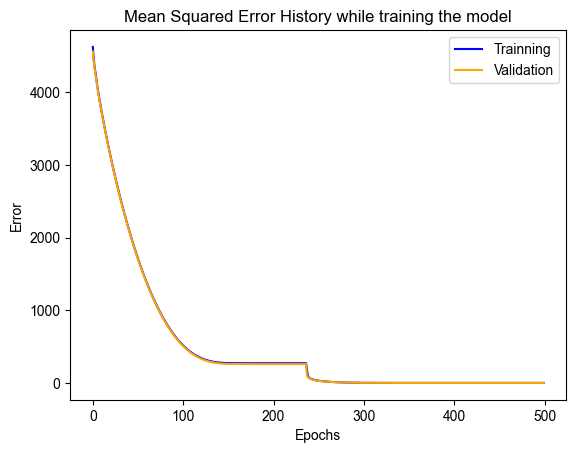

In [27]:
plt.plot(history.history['loss'],color='blue',label='Trainning')
plt.plot(history.history['val_loss'],color='orange',label='Validation')
plt.title('Mean Squared Error History while training the model')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
sns.set_style('whitegrid')
plt.show()

In [41]:
# Make predictions
predictions = model.predict(test_input)

149/149 [==============================] - 1s 1ms/step


In [42]:
predictions.shape

(4758, 1, 1)

In [43]:
test_soc.shape

(4758,)

In [44]:
test_soc = test_soc.reshape(4758,)
y_pred = predictions.reshape(4758,)

In [45]:
mse = mean_squared_error(test_soc, y_pred)
mae = mean_absolute_error(test_soc, y_pred)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(test_soc,y_pred)
r2 = r2_score(test_soc, y_pred)

In [46]:
print(f'Mean Squared Error on Test Set: {mse}')
print(f'Root Mean Squared Error on Test Set: {rmse}')
print(f'Mean Absolute Error on Test Set: {mae}')
print(f'Mean Absolute Percentage Error on Test Set: {mape*100}')
print(f'R2 Score : {r2}')

Mean Squared Error on Test Set: 0.08805579425940269
Root Mean Squared Error on Test Set: 0.29674196578745426
Mean Absolute Error on Test Set: 0.2547079786226097
Mean Absolute Percentage Error on Test Set: 0.4735250215165542
R2 Score : 0.9996868820250808


In [34]:
print(f'Time taken for fitting the model is {a/60} mins')

Time taken for fitting the model is 4.398425436019897 mins


In [47]:
Residual = test_soc - y_pred

In [48]:
df = pd.DataFrame({'Actual': test_soc , 'Predicted': y_pred}).sort_values('Actual',ascending=False)
df.head()

,Actual,Predicted
1640,100.0,99.423042
329,100.0,99.453163
1457,99.0,99.174171
3635,99.0,99.258286
1373,99.0,99.305031


In [49]:
df.tail()

,Actual,Predicted
230,3.0,2.547417
1283,3.0,3.405359
892,3.0,3.703821
2691,2.0,2.655627
118,2.0,2.634506


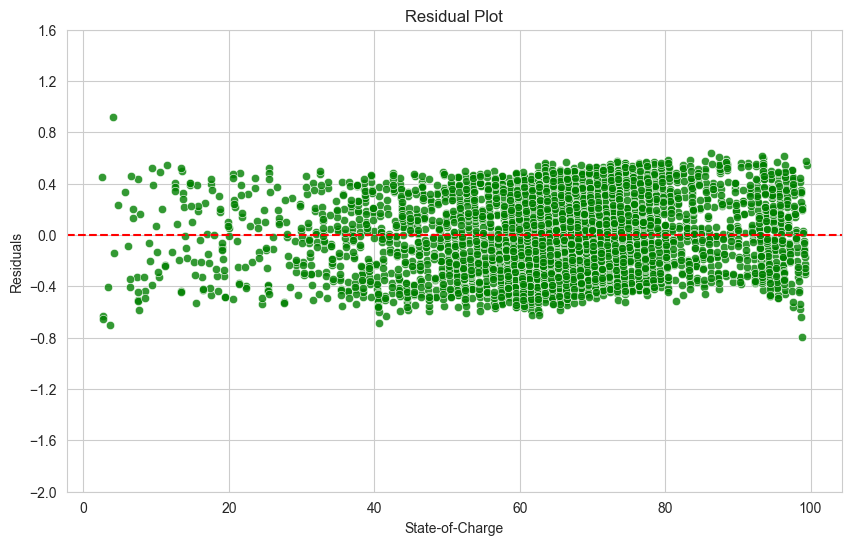

In [50]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=Residual, color='green', alpha=0.8)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('State-of-Charge')
plt.ylabel('Residuals')
plt.ylim(-1.6, 1)  # Set y-axis limits
plt.yticks([i * 0.4 for i in range(-5, 5)])  # Set y-axis ticks
plt.show()

In [39]:
# Save the model to a file
model.save("30deg.h5")